<a href="https://colab.research.google.com/github/aioakiddnh/udemy_lecture_pytorch/blob/master/section3/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataLoader
DataLoaderを使うと、データの読み込みやミニバッチ法の実装などが大幅に楽になります。  
今回は、DataLoaderを使ってデータを扱い、手書き文字の認識を行います。  
なお、今回から学習はGPUを使って行います。  


## データの読み込み
`torchvision.datasets`を使って手書き文字のデータを読み込み、DataLoaderを設定します。  
`torchvision.datasets`にはMNISTの他にも様々なデータセットが用意されています。  
https://pytorch.org/docs/stable/torchvision/datasets.html


In [7]:
import torch #pytorchのインポート
from torchvision.datasets import MNIST #データセットからMNISTのインポート
from torchvision import transforms #前処理のためにtransformsをインポート
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data", 
                    train=True, download=True,
                    transform=transforms.ToTensor()) #transforms.ToTensor()：Tensorに変換。変換しないとpil形式の画像データになる。
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 256 #バッチサイズは少々多めに設定。GPUの威力を分かりやすくするため。
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True) #shuffle=True：訓練データからランダムにバッチが取り出されるようになる。
test_loader = DataLoader(mnist_test,
                          batch_size=batch_size,
                          shuffle=False)

訓練データの数: 60000 テストデータの数: 10000


手書き文字の画像サイズは、28×28になります。  



## モデルの構築
今回は、`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
`.cuda()`により、モデルの計算はGPU上で行われるようになります。  

In [8]:
import torch.nn as nn #ニューラルネットワーク
import torch.nn.functional as F #活性化関数などが入っている。

class Net(nn.Module): #nn.Moduleを継承
    def __init__(self):
        super().__init__() #継承元クラスのinitializerを実行
        #↓層の設定
        self.fc1 = nn.Linear(img_size*img_size, 1024) #全結合層：前の層のニューロンとすべて接続されている。 入力は画像のサイズ(28×28)。最初の中間層のニューロン数は1024。
        self.fc2 = nn.Linear(1024, 512) # 全結合層 2つ目の中間層のニューロン数は512
        self.fc3 = nn.Linear(512, 10) # 全結合層 出力層のニューロン数は10
    
    def forward(self, x): #順伝播
        x = x.view(-1, img_size*img_size) # バッチサイズ×入力の数。 #形状を整える。viewはTensorの形状を変更するのに使う。バッチサイズは柔軟に対応するために-1(行の数を自動設定)
        x = F.relu(self.fc1(x)) #全結合層の処理をした後、活性化関数のreluに入れてあげる。
        x = F.relu(self.fc2(x)) #上の結果をfc2に入れて、またreluに入れる。
        x = self.fc3(x) #最後にfc3に入れる。
        return x
    
    #back word methodは無い。設定しなくても、自動微分機能で自動で計算してくれる。なので、順伝播のみforward methodで設定すれば良い。

net = Net() #インスタンス生成
net.cuda() #インスタンスに対してGPUを設定。pytorchでは、.cuda()という関数を設定するだけでこの計算がGPU上で行われるようになる。
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法が実装されていることになります。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [9]:
from torch import optim #最適化アルゴリズムのoptimをインポート

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss() #損失関数の設定を行う。 

# SGD 
optimizer = optim.SGD(net.parameters(), lr=0.01) #最適化アルゴリズム #今回は一番シンプルなSGDを設定 #学習率lrは0.01 #引数としてパラメータを渡している。

# 損失のログ
record_loss_train = [] #訓練用
record_loss_test = [] #テスト用

# 学習
for i in range(10): # 10エポック学習 #今回は訓練データの数が多いので10エポックのみにする。これ以上増えてしまうと、今回の講義の中で学習が終わらなくなってしまうので少なめにしている。
    net.train() # 訓練モード
    loss_train = 0 # 訓練用の誤差。最初0にしておく。
    for j, (x, t) in enumerate(train_loader): # ミニバッチ(x, t)を取り出す。x:入力(画像), t:正解(ラベル)
        x, t = x.cuda(), t.cuda() #GPU対応 #xとtがGPU上のメモリに配置される。
        y = net(x) #先ほどGPU対応したnet()にxを入れることによってyを計算することが出来る。
        loss = loss_fnc(y, t) #出力と正解を使って誤差を計算
        loss_train += loss.item() #誤差の累積 #1エポック終了後の誤差とは違うが、いわゆるラーニングエラーと呼ばれる誤差をここでは計算している。
        optimizer.zero_grad() #累積された勾配をすべて0に設定
        loss.backward() #逆伝播が行われて各パラメータの勾配が計算される。
        optimizer.step() #勾配を計算するだけではだめで、更新しないといけない。 step()でパラメータの更新
    loss_train /= j+1 #1エポック終了後に、1エポック内のバッチの数で割ってあげることで平均をとっている。
    record_loss_train.append(loss_train) #訓練誤差の記録。

    net.eval() # 評価モード #1エポックごとに評価を行う。 #ここではパラメータの更新などは行われない。
    loss_test = 0 # これに誤差を累積していく。
    for j, (x, t) in enumerate(test_loader): # ミニバッチ(x, t)を取り出す。
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
      print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test) #エポックごとの結果。訓練誤差とテスト誤差の結果

Epoch: 0 Loss_Train: 2.222446347297506 Loss_Test: 2.101173633337021
Epoch: 1 Loss_Train: 1.8398723333439928 Loss_Test: 1.454887929558754
Epoch: 2 Loss_Train: 1.1278286261761443 Loss_Test: 0.8386905789375305
Epoch: 3 Loss_Train: 0.7304400309603265 Loss_Test: 0.605303780734539
Epoch: 4 Loss_Train: 0.5693780844515942 Loss_Test: 0.49696029908955097
Epoch: 5 Loss_Train: 0.4868146588193609 Loss_Test: 0.4351027563214302
Epoch: 6 Loss_Train: 0.4375170645561624 Loss_Test: 0.39882552791386844
Epoch: 7 Loss_Train: 0.4044622806792564 Loss_Test: 0.37155286986380814
Epoch: 8 Loss_Train: 0.3815412554335087 Loss_Test: 0.35200091134756806
Epoch: 9 Loss_Train: 0.3632543979807103 Loss_Test: 0.3368161192163825


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

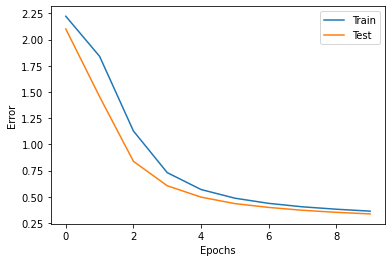

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [11]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda() #GPU対応
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")


正解率: 90.36%
